In [1]:
import numpy as np

import torch
from torch import nn
from torch.func import vmap, vjp, jacrev

import matplotlib.pyplot as plt
from dataclasses import dataclass

import NNs
import geometry 
import manifolds
import metrics

from utils import RelativeDiff
dtype = torch.float32


In [2]:
#--- Load the models and construct the manifold ---#
device = torch.device('cpu')

k = 5
z_cutoff = .99
width = 10
depth = 2
activation = 'tanh'
sampling_method = 'volume'
conformal_factor = 100

if k == 5:
    gamma_1 = 8.0 
    shift_1 = -3./4. 

    gamma_2 = 3.
    shift_2 = 0. 

rel_diff_object = RelativeDiff()

@dataclass
class network_config:
    input_dim:        int = 3
    output_dim:       int = 1
    width:            int = width       
    depth:            int = depth 
    activation:       str = activation 

#----- Define the models -----#
models_to_pre_train = [NNs.Res_FC(network_config).to(device) for _ in range(3)]    #These are the ones not inialized to zero
models_to_pre_train.append(NNs.Res_FC_zero(network_config).to(device))
models_zero = [NNs.Res_FC_zero(network_config).to(device) for _ in range(2)]   #These are the ones initialized to zero
models = models_to_pre_train+models_zero


m3 = manifolds.M3(sampling_method = sampling_method, k = k, z_cutoff = z_cutoff, dtype = dtype)


def ricci_comp_plot(inputs):
    christ = compute_christoffel_batched(inputs)
    diff_christ = compute_diff_christoffel_batched(inputs)
    return ricci_batched( christ, diff_christ)


def ricci_scal_plot(inputs):
    christ = compute_christoffel_batched(inputs)
    diff_christ = compute_diff_christoffel_batched(inputs)
    gmn = metric_from_NN_batched(inputs)
    return ricci_scalar_batched(gmn, christ, diff_christ)


fixed_x = torch.tensor(0.5, device = device)
fixed_y = torch.tensor(0.5, device = device)
min_z = 1/np.sqrt(2)
max_z = z_cutoff*m3.rj
plot_points = 300


## These are the input points where to evaluate the curvature
z = torch.linspace(min_z, max_z, plot_points,  device=device)
Z, X, Y = torch.meshgrid(z, fixed_x, fixed_y, indexing='ij')
batch_tensors = torch.stack((Z.squeeze(), X.squeeze(), Y.squeeze()), dim=1)
batch_tensors.to(device);



In [3]:
#----- Initialize the metrics -----#
metric_from_NN = metrics.non_diagonal_metric(m3, models, dtype = dtype)  
metric_from_NN_batched = vmap(metric_from_NN.metric)    

compute_christoffel_batched = vmap(metric_from_NN.compute_christoffel)
compute_diff_christoffel_batched = vmap(metric_from_NN.der_christoffel)
ricci_scalar_batched = vmap(geometry.ricci_scalar)
ricci_batched = vmap(geometry.ricci)


In [4]:
#Pre-trained metric
loadname = 'saved-models/uukbopzj-pretrained' 
for i in range(len(models)): models[i].load_state_dict(torch.load(f'{loadname}-model{i}.pth', map_location = device.type, weights_only=True))

ricci_comp_pre = ricci_comp_plot(batch_tensors)
gmn_pre = metric_from_NN_batched(batch_tensors)
ricci_scalar_pre = ricci_scal_plot(batch_tensors)



In [5]:
# After training
loadname = 'saved-models/e8rbmul1'  
for i in range(len(models)): models[i].load_state_dict(torch.load(f'{loadname}-model{i}.pth', map_location = device.type, weights_only=True))

ricci_comp = ricci_comp_plot(batch_tensors)
gmn = metric_from_NN_batched(batch_tensors)
ricci_scalar = ricci_scal_plot(batch_tensors)


In [6]:
## Manual interpolations as comparisons
met_1 = metrics.approximate_DF(m3, dtype = dtype, gamma = gamma_1, shift = shift_1)
metric_DF_interp_batched_1 = vmap(met_1.metric_DF_interp)

compute_christoffel_interp_batched_1 = vmap(met_1.compute_christoffel_interp)
compute_diff_christoffel_interp_batched_1 = vmap(met_1.der_christoffel_interp)

def ricci_comp_plot_interp_1(inputs):
    christ = compute_christoffel_interp_batched_1(inputs)
    diff_christ = compute_diff_christoffel_interp_batched_1(inputs)
    return ricci_batched( christ, diff_christ)



def ricci_scal_plot_interp_1(inputs):
    christ = compute_christoffel_interp_batched_1(inputs)
    diff_christ = compute_diff_christoffel_interp_batched_1(inputs)
    gmn = metric_DF_interp_batched_1(inputs)
    return ricci_scalar_batched(gmn, christ, diff_christ)


met_2 = metrics.approximate_DF(m3, dtype = dtype, gamma = gamma_2, shift = shift_2)
metric_DF_interp_batched_2 = vmap(met_2.metric_DF_interp)

compute_christoffel_interp_batched_2 = vmap(met_2.compute_christoffel_interp)
compute_diff_christoffel_interp_batched_2 = vmap(met_2.der_christoffel_interp)

def ricci_comp_plot_interp_2(inputs):
    christ = compute_christoffel_interp_batched_2(inputs)
    diff_christ = compute_diff_christoffel_interp_batched_2(inputs)
    return ricci_batched(christ, diff_christ)


def ricci_scal_plot_interp_2(inputs):
    christ = compute_christoffel_interp_batched_2(inputs)
    diff_christ = compute_diff_christoffel_interp_batched_2(inputs)
    gmn = metric_DF_interp_batched_2(inputs)
    return ricci_scalar_batched(gmn, christ, diff_christ)


ricci_comp_interp_1 = ricci_comp_plot_interp_1(batch_tensors)
gmn_interp_1 = metric_DF_interp_batched_1(batch_tensors)
ricci_scalar_interp_1 = ricci_scal_plot_interp_1(batch_tensors)

ricci_comp_interp_2 = ricci_comp_plot_interp_2(batch_tensors)
gmn_interp_2 = metric_DF_interp_batched_2(batch_tensors)
ricci_scalar_interp_2 = ricci_scal_plot_interp_2(batch_tensors)


Plot the Ricci scalar comparison

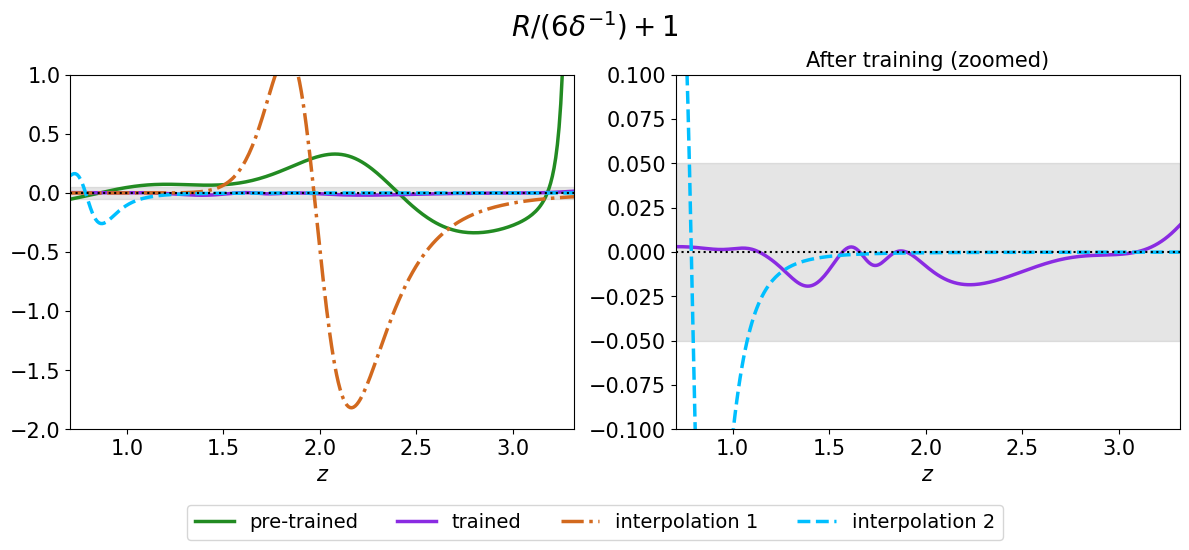

In [7]:
ricci_scalar_toplot = ricci_scalar/(6/(conformal_factor))+1
ricci_scalar_pre_toplot = ricci_scalar_pre/(6/(conformal_factor))+1
ricci_scalar_interp_1_toplot = ricci_scalar_interp_1/(6)+1
ricci_scalar_interp_2_toplot = ricci_scalar_interp_2/(6)+1


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

fig.suptitle(r'$R/(6\delta^{-1}) + 1$', fontsize=20)

linewidth=2.5

ax1.plot(z.cpu().numpy(), ricci_scalar_pre_toplot.detach().cpu().numpy(), color='forestgreen', linewidth = linewidth, label = "pre-trained")
ax1.plot(z.cpu().numpy(), ricci_scalar_toplot.detach().cpu().numpy(), color='blueviolet', linewidth = linewidth, label = "trained")
ax1.plot(z.cpu().numpy(), ricci_scalar_interp_1_toplot.detach().cpu().numpy(), color='chocolate',  linestyle='-.', linewidth = linewidth, label = "interpolation 1")
ax1.plot(z.cpu().numpy(), ricci_scalar_interp_2_toplot.detach().cpu().numpy(), color='deepskyblue',  linestyle='dashed', linewidth = linewidth, label = "interpolation 2")



ax1.plot([min_z, max_z], [0, 0], color='black', linestyle='dotted')
ax1.set_xlabel(r'$z$', fontsize=15)
ax1.tick_params(axis='both', labelsize=15)
ax1.fill_between(z.cpu().numpy(), -0.05, 0.05, color='gray', alpha=0.2)
ax2.plot(z.cpu().numpy(), ricci_scalar_toplot.detach().cpu().numpy(), color='blueviolet', linewidth = linewidth)
ax2.plot(z.cpu().numpy(), ricci_scalar_interp_2_toplot.detach().cpu().numpy(), color='deepskyblue', linestyle='dashed', linewidth = linewidth)

ax2.plot([min_z, max_z], [0, 0], color='black', linestyle='dotted')
ax2.set_xlabel(r'$z$', fontsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax2.set_title('After training (zoomed)', fontsize=15)
ax2.fill_between(z.cpu().numpy(), -0.05, 0.05, color='gray', alpha=0.2)

ax2.set_ylim(-0.1, 0.1)  
ax1.set_ylim(-2, 1) 

ax1.set_xlim(min_z, max_z)
ax2.set_xlim(min_z, max_z)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

Plotting the components of the Ricci tensor

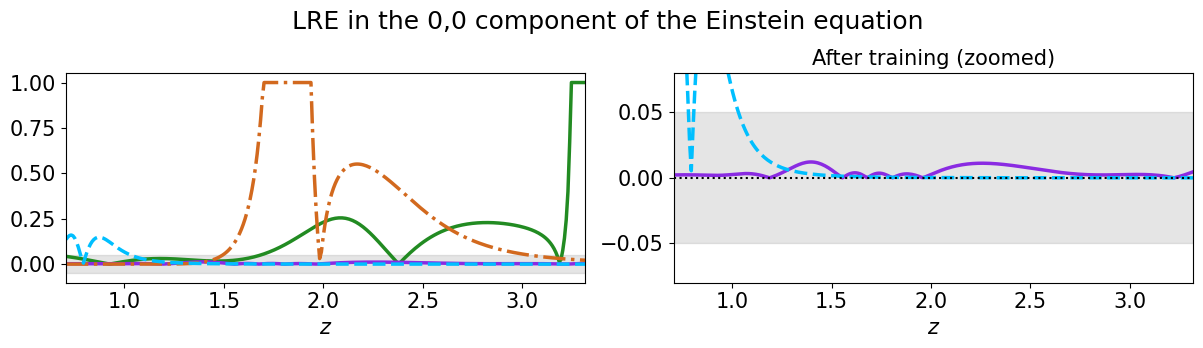

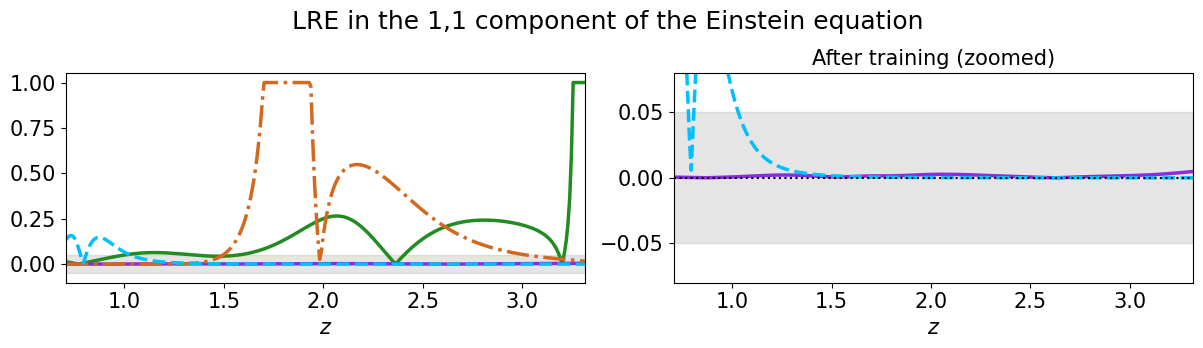

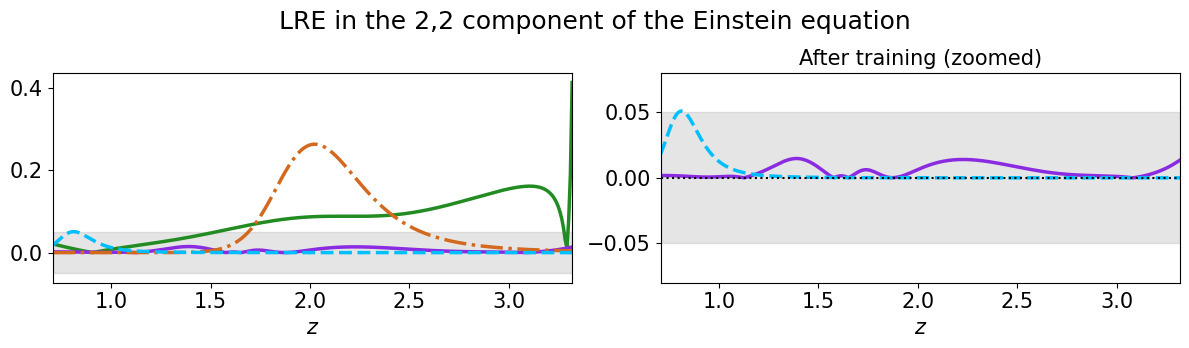

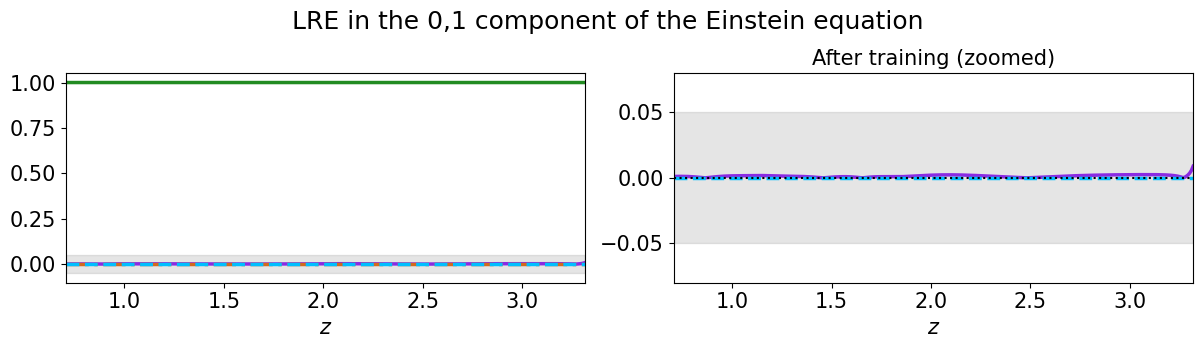

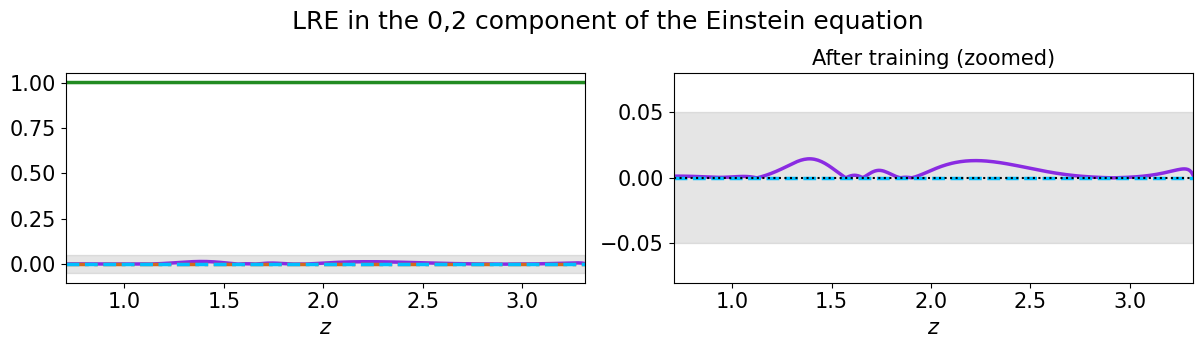

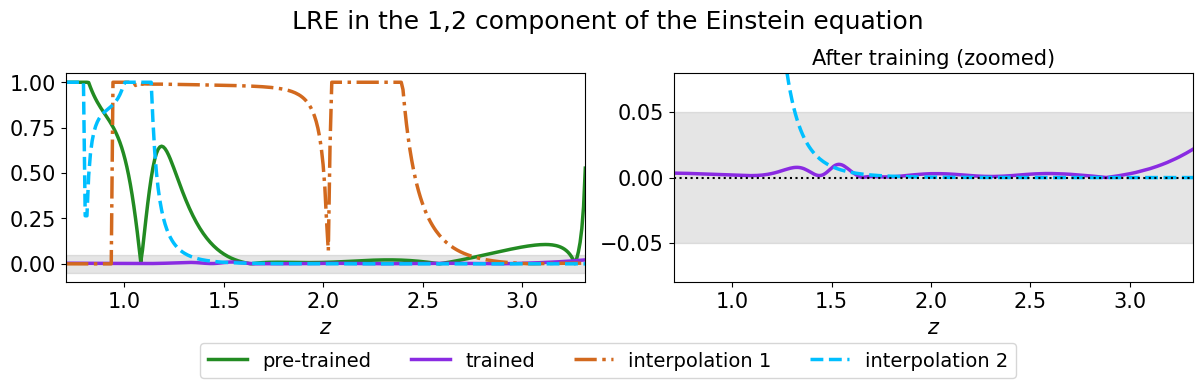

In [8]:
for components in [ [0,0], [1,1], [2,2], [0,1], [0,2], [1,2]]:
    to_plot_pre = torch.abs(rel_diff_object.relative_diff(ricci_comp_pre[:,components[0], components[1]], -2*(1./conformal_factor)*gmn_pre[:, components[0], components[1]]))
    to_plot_tra = torch.abs(rel_diff_object.relative_diff(ricci_comp[:,components[0], components[1]], -2*(1./conformal_factor)*gmn[:, components[0], components[1]]))
    to_plot_interp_1 = torch.abs(rel_diff_object.relative_diff(ricci_comp_interp_1[:,components[0], components[1]], -2*gmn_interp_1[:, components[0], components[1]]))
    to_plot_interp_2 = torch.abs(rel_diff_object.relative_diff(ricci_comp_interp_2[:,components[0], components[1]], -2*gmn_interp_2[:, components[0], components[1]]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3.5))

    fig.suptitle(f'LRE in the {components[0]},{components[1]} component of the Einstein equation', fontsize=18)

    linewidth=2.5
    ax1.plot(z.cpu().numpy(), to_plot_pre.detach().cpu().numpy(), color='forestgreen', linewidth = linewidth, label = "pre-trained")
    ax1.plot(z.cpu().numpy(), to_plot_tra.detach().cpu().numpy(), color='blueviolet', linewidth = linewidth, label = "trained")
    ax1.plot(z.cpu().numpy(), to_plot_interp_1.detach().cpu().numpy(), color='chocolate',  linestyle='-.', linewidth = linewidth, label = "interpolation 1")
    ax1.plot(z.cpu().numpy(), to_plot_interp_2.detach().cpu().numpy(), color='deepskyblue',  linestyle='dashed', linewidth = linewidth, label = "interpolation 2")

    ax1.set_xlabel(r'$z$', fontsize=15)
    ax1.tick_params(axis='both', labelsize=15)
    ax1.fill_between(z.cpu().numpy(), -0.05, 0.05, color='gray', alpha=0.2)

    ax2.plot(z.cpu().numpy(), to_plot_tra.detach().cpu().numpy(), color='blueviolet', linewidth = linewidth)
    ax2.plot(z.cpu().numpy(), to_plot_interp_2.detach().cpu().numpy(), color='deepskyblue', linestyle='dashed', linewidth = linewidth)
    ax2.plot([min_z, max_z], [0, 0], color='black', linestyle='dotted')

    ax2.set_xlabel(r'$z$', fontsize=15)
    ax2.tick_params(axis='both', labelsize=15)
    ax2.set_title('After training (zoomed)', fontsize=15)
    ax2.fill_between(z.cpu().numpy(), -0.05, 0.05, color='gray', alpha=0.2)

    ax2.set_ylim(-0.08, 0.08) 

    ax1.set_xlim(min_z, max_z)
    ax2.set_xlim(min_z, max_z)
    if components[0] == 1 and components[1] == 2: fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.show()
